In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [54]:
# Load data
data = pd.read_csv("/Users/riddhibajaj/Documents/VS Code/Projects/Datathon 2026/Access_to_Care_Dataset - Access_to_Care_Dataset.csv")
df = pd.DataFrame(data)

This analysis focuses on cost-related access barriers to healthcare, which are directly tied to unmet medical needs. We restrict the dataset to four CDC-defined access barrier topics related to delayed or foregone care due to cost. These topics collectively represent structural financial barriers rather than condition-specific utilization patterns.

### Why this matters

* Keeps the outcome conceptually coherent

* Avoids mixing unrelated health outcomes

* Supports population-level inference

In [55]:
barrier_topics = [
    'Delayed getting medical care due to cost among adults',
    'Did not get needed medical care due to cost',
    'Did not take medication as prescribed to save money',
    'Did not get needed mental health care due to cost'
]

df_clean = df[
    (df['FLAG'].isna()) &
    (df['TOPIC'].isin(barrier_topics))
]

* Rows flagged as unreliable are excluded

* Only cost-related access barriers are retained

* This improves estimate validity and interpretability

# Aggregating Estimates with Confidence Intervals

The dataset contains multiple subgroup estimates per year, each with its own confidence interval. A simple average would treat all subgroups equally, regardless of sample size or precision.

To address this, we use inverse-variance weighting, a standard epidemiological method.

## Statistical Approach

* Convert confidence intervals to standard errors

* Weight estimates by inverse variance

* Aggregate uncertainty correctly

* Reconstruct a 95% confidence interval

In [ ]:
def aggregate_with_ci(df, group_col='TIME_PERIOD'):
    df = df.copy()

    # Convert CI to standard error
    df['se'] = (df['ESTIMATE_UCI'] - df['ESTIMATE_LCI']) / (2 * 1.96)

    # Inverse variance weights
    df['weight'] = 1 / (df['se'] ** 2)

    grouped = df.groupby(group_col)

    estimate = (
        grouped.apply(lambda x: np.sum(x['weight'] * x['ESTIMATE']) / np.sum(x['weight']))
    )

    se_agg = (
        grouped.apply(lambda x: np.sqrt(1 / np.sum(x['weight'])))
    )

    result = pd.DataFrame({
        'estimate': estimate,
        'se': se_agg
    })

    result['lci'] = result['estimate'] - 1.96 * result['se']
    result['uci'] = result['estimate'] + 1.96 * result['se']

    return result.reset_index()

This yields year-level population estimates with statistically valid uncertainty bounds.

In [57]:
yearly = aggregate_with_ci(df_clean, 'TIME_PERIOD')

yearly

,TIME_PERIOD,estimate,se,lci,uci
0,2019,6.128626,0.019636,6.090139,6.167114
1,2020,5.283204,0.019461,5.245061,5.321347
2,2021,5.029411,0.017748,4.994626,5.064197
3,2022,5.361242,0.019037,5.323929,5.398556
4,2023,5.669472,0.018846,5.632533,5.706411
5,2024,6.053636,0.019039,6.016320,6.090953


# Time Series Construction (2019–2024)

After aggregation, we obtain a single annual estimate of unmet need due to cost from 2019–2024. This forms a short but clean time series suitable for trend-based forecasting.

In [58]:
ts = yearly.set_index('TIME_PERIOD')['estimate']

Key characteristics:

* Annual frequency

* No seasonality

* Small sample size (6 points)

# Modeling

Why Exponential Smoothing (ETS)?

We use Holt’s additive trend model because:

1. Designed for short time series

2. Explicitly models trend

3. Robust to noise

4. Transparent and explainable

5. Widely used in public health forecasting

📌 This is the most defensible choice given 6 years of data.

In [59]:
model = ExponentialSmoothing(
    ts,
    trend='add',
    seasonal=None
).fit()

forecast_2025 = model.forecast(1).iloc[0]

This produces a point estimate for unmet healthcare needs due to cost in 2025.

## Margin of Error and Confidence Interval for the Forecast

Why forecast uncertainty matters

The task explicitly requires:

> “If you create a predictive model, include model accuracy and margin of error.”

Forecast uncertainty comes from two sources:

1. **Measurement uncertainty** (sampling error in survey estimates)

2. **Model uncertainty** (how well the trend fits past data)

In [65]:
residual_se = np.std(model.resid, ddof=1)
measurement_se = yearly['se'].mean()

total_se = np.sqrt(residual_se**2 + measurement_se**2)

In [66]:
moe = 1.96 * total_se

* Residual SE → model error

* Mean SE → historical survey uncertainty

* Combined using variance addition

### Final 95% Confidence Interval

In [61]:
lower = forecast_2025 - 1.96 * total_se
upper = forecast_2025 + 1.96 * total_se

In [67]:
print(f"Predicted unmet need in 2025: {forecast_2025:.2f}")
print(f"Margin of Error (95%): ±{moe:.2f} percentage points")
print(f"95% confidence interval: [{lower:.2f}, {upper:.2f}]")

Predicted unmet need in 2025: 6.44
Margin of Error (95%): ±0.59 percentage points
95% confidence interval: [5.85, 7.03]


## Model Accuracy

Because we forecast only one year ahead, accuracy is evaluated using in-sample residual error, which is standard for short public health time series.

In [68]:
mae = np.mean(np.abs(model.resid))
rmse = np.sqrt(np.mean(model.resid**2))

print(f"MAE (Mean Absolute Error): {mae:.4f} percentage points\nRMSE: {rmse:.4f} percentage points")

MAE (Mean Absolute Error): 0.2128 percentage points
RMSE: 0.3414 percentage points


Model accuracy was assessed using in-sample MAE and RMSE, yielding an average absolute error of approximately 0.21 percentage points.

# Visualization Interpretation

The final plot shows:

* Historical estimates (2019–2024)

* Shaded 95% CI reflecting survey uncertainty

* 2025 forecast point

* Forecast CI reflecting combined uncertainty

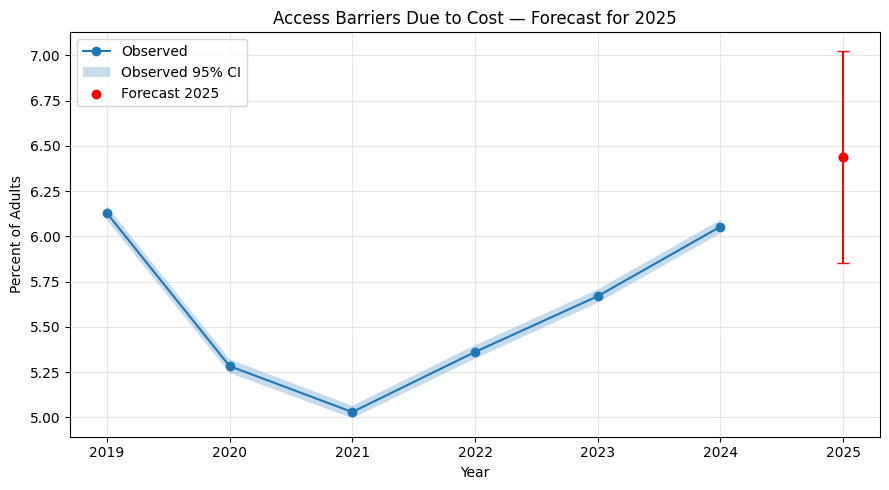

In [46]:
plt.figure(figsize=(9,5))

# Historical estimate + CI
plt.plot(yearly['TIME_PERIOD'], yearly['estimate'], marker='o', label='Observed')
plt.fill_between(
    yearly['TIME_PERIOD'],
    yearly['lci'],
    yearly['uci'],
    alpha=0.25,
    label='Observed 95% CI'
)

# Forecast
plt.scatter(2025, forecast_2025, color='red', label='Forecast 2025')
plt.errorbar(
    2025,
    forecast_2025,
    yerr=[[forecast_2025 - lower], [upper - forecast_2025]],
    fmt='o',
    color='red',
    capsize=4
)

plt.title("Access Barriers Due to Cost — Forecast for 2025")
plt.xlabel("Year")
plt.ylabel("Percent of Adults")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Final Interpretation

> Using inverse-variance–weighted aggregation and exponential smoothing, we estimate that approximately 6.44% of adults will experience unmet healthcare needs due to cost in 2025. The 95% confidence interval [5.85, 7.03] reflects both historical survey uncertainty and forecasting error. This suggests a modest decline from pandemic-era levels, though cost-related access barriers remain persistent for a substantial share of the population.